In [82]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
!pip install langchain sentence-transformers faiss-cpu pypdf transformers torch langchain-community

In [84]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.llms import HuggingFacePipeline
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, AutoModelForSeq2SeqLM
from langchain.chains import RetrievalQA

# Asystent AI - PDF RAG

Po dwóch udanych misjach – rozwikłaniu tajemnicy przeżycia na Titanicu i odczytaniu ręcznych notatek o pokojach – myślałeś, że zasłużysz na odpoczynek. Jednak telefon od tajemniczego zleceniodawcy rozbrzmiał ponownie, tym razem z jeszcze pilniejszą sprawą.

"Wasze poprzednie modele były kluczowe," – rozpoczął głos w słuchawce – "ale to dopiero wstęp do prawdziwego wyzwania. Nasi agenci przechwycili poufny szpont dokumentów. To nie są zwykłe papiery; to zestaw od 3 do 5 artykułów naukowych w formacie PDF, które zawierają fragmenty przełomowych badań. Informacje są niekompletne, celowo pomieszane i zaszyfrowane."

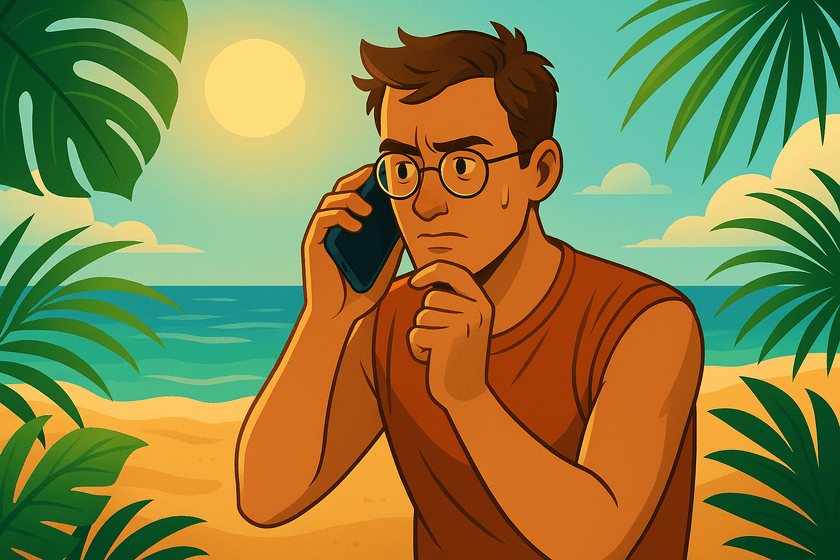

(*AI-generated image*)

Twoim celem będzie stworzenie asystenta RAG - Retrival Augmented Generation na podstawie kilku plików PDF z artykułami naukowymi na wybrany przez siebie temat (3-5 artykułów).

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:
- Czy model poprawnie odpowiada na pytania ?
- Jakie są etapy przetwarzania dokumentu tekstowego ?
- Jaki wynik jest "dobry" ?
- Co robi mój asystent AI ? Jak on działa ? Jak tworzona jest odpowiedź ?
- Czy model poprawnie wybiera fragment dokumentu ? Czy poprawnie korzysta z bazy ?
- Jaką rolę w naszym systemie pełni baza wektorowa ?

Wymagania:
- Przygotuj artykuły naukowe i umieść je w folderze na dysku
- Stwórz wektorową bazę danych (można użyć innego systemu niż FAISS)
- Zapełnij bazę embeddingami z modelu wybranego przez Ciebie z [Sentence Similarity Models](https://huggingface.co/models?pipeline_tag=sentence-similarity&sort=trending) z HuggingFace Hub - innego niż podany w notebooku wzorcowym
- Zainicjuj wybrany model QA z dostępnych [Question Answering Models](https://huggingface.co/models?pipeline_tag=question-answering&sort=trending) z HuggingFace Hub - również innego niż w notebooku wzorcowym
- Stwórz chaina odpowiadania na pytania i dodaj mechanizm pętli - tak, żeby można było przeprowadzać swobodną rozmowę z asystentem

**Dodatkowe wymagania**
- Mechanizm pamięci konwersacji - tak, żeby model pamiętał poprzednią część konwersacji
- Mechanizm braku halucynacji (bez cyberpsychozy) - jeśli model nie znajdzie odpowiedzi w bazie, informuje o tym
- Cytowanie dokumentu, z którego model pobrał informacje

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza Markdown.






# Artykuły

Mój asystent RAG będzie bazował na trzech artykułach:
- A Practical and Contemporary Model of Depression for Our Times — A Timeless Existential Clinician’s Perspective ('article1')
- Beck’s Cognitive Model of Depression: Evolution, Modern Evidence and Critical Appraisal ('article2')
- Biological, Psychological, and Social Determinants of Depression: A Review of Recent Literature ('article3')

Wszystkie powyższe artykuły są w formacie .pdf

## Ładowanie i przetwarzanie artykułów

In [85]:
paths = ['/content/drive/My Drive/data/article1.pdf',
         '/content/drive/My Drive/data/article2.pdf',
         '/content/drive/My Drive/data/article3.pdf']

loaders = [PyPDFLoader(path) for path in paths]
pages = [loader.load() for loader in loaders]

rows = len(pages)
cols = [len(page) for page in pages]
rows, cols

(3, [36, 14, 33])

In [86]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=300,
    chunk_overlap=100,
    length_function=len,
    separators=["\n\n", "\n", " ", ""]
)

all_pages = [page for sublist in pages for page in sublist]
docs = text_splitter.split_documents(all_pages)

for idx,doc in enumerate(docs):
  print(f"[{idx}].{doc}\n\n")

[0].page_content='Open Journal of Depression, 2021, 10, 54-89 
https://www.scirp.org/journal/ojd 
ISSN Online: 2169-9674 
ISSN Print: 2169-9658 
 
DOI: 10.4236/ojd.2021.102005  May 18, 2021 54 Open Journal of Depression 
 
 
 
 
A Practical and Contemporary Model of 
Depression for Our Times—A Timeless' metadata={'producer': 'Adobe PDF Library 11.0', 'creator': 'Acrobat PDFMaker 11 Word 版', 'creationdate': '2021-05-17T14:11:41+08:00', 'author': 'Sebastian Salicru', 'company': 'Microsoft', 'keywords': 'Depression, Existential, Humanistic, Experiential Therapies, Psychotherapy Integration, Meaning, Purpose, Authenticity, Freedom, Responsibility', 'moddate': '2021-05-17T14:11:45+08:00', 'sourcemodified': 'D:20210517061122', 'subject': 'Problem: Depression is spreading rapidly worldwide. It has been forecasted to become the leading cause of disability worldwide by 2030, despite significant efforts and investments made to treat it. This menace has been exacerbated by the current COVID-19 pa

# Wektorowa baza danych + embedding

Zgodnie z wymaganiami (cytowanie, brak cyberpsychozy, pamięć zapytań) wybrałam embedding "BAAI/bge-large-en-v1.5". To model, który osiąga topowe wyniki w semantycznym wyszukiwaniu, jest stabilny i dobrze współpracuje z LangChain oraz Pinecone.

In [87]:
embedding_model = HuggingFaceEmbeddings(
    model_name="BAAI/bge-large-en-v1.5",
    encode_kwargs={"normalize_embeddings": True} # normalizacja
)

Normalizujemy embeddingu, ponieważ większość baz wektorowych — w tym FAISS — używa cosine similarity jako metryki porównania, która działa najlepiej, gdy wektory są znormalizowane.


In [88]:
'''
db = FAISS.from_documents(docs, embedding_model)
db.save_local("faiss_index_bge")
'''

'\ndb = FAISS.from_documents(docs, embedding_model)\ndb.save_local("faiss_index_bge")\n'

Powyższy kod mielił ponad pół godziny więc się poddałam i spróbuję innego embeddingu. Ten który wybrałam był super jeśli chodzi o dokładność ale ze względu na to że pracuje na laptopie z cpu to nie wyrobił. Poniższy embedding też dobrze działa (mimo że ma 768 wymiarów zamiast 1024) i figuruje na wysokom miejscu w 'HuggingFace embeddings leaderboard'.

In [89]:
embedding_model = HuggingFaceEmbeddings(
    model_name="sentence-transformers/paraphrase-mpnet-base-v2",
    encode_kwargs={"normalize_embeddings": True}
)

In [90]:
'''
db = FAISS.from_documents(docs, embedding_model)
db.save_local("faiss_index_inny")
'''

'\ndb = FAISS.from_documents(docs, embedding_model)\ndb.save_local("faiss_index_inny")\n'

Mieliło 11 min.

# Retrieval - podobne fragmenty

In [91]:
db = FAISS.load_local("faiss_index_inny", embedding_model, allow_dangerous_deserialization=True)

query = 'What is the cause of depression?'
similar_docs = db.similarity_search(query, k=5)

for doc in similar_docs:
    print('...' + doc.page_content[:300] + "...\n")

...that it is a burdensome condition with a negative impact on educational trajectories, work
performance, and other areas of life [1,3]. Depression can start early in the lifecourse and,
if it remains unmanaged, may increase the risk for substance abuse, chronic conditions,...

...1985). Specifically, symptoms of depression are viewed as a primary cause, leading 
to negative automatic thoughts, cognitive triad, cognitive errors and dysfunctional 
attitudes in succession (Kwon & Oei, 1992). In this vein, the bodily, affective and...

...Psychotherapies 
The exact etiology of depression is unknown. Hence, multiple explanatory the o-
ries and models (medical, genetic, and biopsychosocial) have been proposed to 
understand, prevent, and treat it. Nonetheless, depression is known to be more...

...condition. The ﬁndings from this review show that there are important themes when it
comes to the determinants of depression, such as: the microbiome, dysregulation of the
HPA axis, inﬂammatory r

Klasyczny retrieval poradził sobie całkiem dobrze, niby uzyskałam odpowiedź na moje pytanie dla k=4, jednak jest ona niezadowalająca. Spróbuję znaleźć lepsze fragmenty.

In [92]:
results = db.similarity_search_with_score(query, k=10)

for doc, score in results:
    if score < 0.7:
        continue
    print('...' + doc.page_content[:300] + "...\n")

...crime exposure, abuse, discrimination, (self)-stigma, ethnicity and migrant status, working
conditions, adverse or signiﬁcant life events, illiteracy or health literacy, environmen-
tal events, job strain, and the built environment have been linked to depression, among...

...thorough synthesis of the literature assessing the biological, psychological, and social determinants
of depression in order to piece together the puzzle of the key factors that are related to this condition....

...al., 2019). Hence, more than ever before, depression constitutes an extremely s e-
rious public health issue which is projected to become the leading cause of dis a-
bility worldwide by 2030 ( Ebert & Cuijpers, 2018 ). These research findings are...

...• Determinants of depression include negative self-concept, sensitivity to rejection,
neuroticism, rumination, negative emotionality, and others
A number of studies have been undertaken on the psychological factors linked to...



# Model QA (ekstrakcyjny)

In [93]:
results = db.similarity_search_with_score(query, k=10)
filtered_docs = [doc for doc, score in results if score >= 0.7]
context_0 = " ".join([doc.page_content for doc in filtered_docs])

In [94]:
qa_model = pipeline("question-answering", model="deepset/roberta-base-squad2")

response = qa_model(question=query, context=context_0)
print(f"Odpowiedź: {response['answer']}")
print(f"Trafność: {response['score']:.2f}")

Fetching 0 files: 0it [00:00, ?it/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 0 files: 0it [00:00, ?it/s]

Device set to use cpu


Odpowiedź: dis a-
bility
Trafność: 0.03


In [95]:
results = db.similarity_search_with_score(query, k=20)
filtered_docs = [doc for doc, score in results if score >= 0.5]
context_1 = " ".join([doc.page_content for doc in filtered_docs])

In [96]:
response = qa_model(question=query, context=context_1)
print(f"Odpowiedź: {response['answer']}")
print(f"Trafność: {response['score']:.2f}")

Odpowiedź: symptoms
Trafność: 0.19


Mega słabo to idzie - używany model tylko i wyłącznie 'wycina' odpowiedź (to model ekstrakcyjny) - nie syntetyzuje jej. Spróbuję użyć innego modelu.

# Model QA (generatywny) - 1

In [97]:
results = db.similarity_search_with_score(query, k=8)
filtered = [(doc, score) for doc, score in results if score >= 0.5]
context_2 = " ".join([doc.page_content for doc, score in filtered])

In [98]:
model_name = "MBZUAI/LaMini-Flan-T5-77M"
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

qa_pipe = pipeline(
    "text2text-generation",
    model=model,
    tokenizer=tokenizer,
    )

prompt = f"Question: {query}, Context: {context_2}"
response = qa_pipe(prompt)
print(response[0]['generated_text'])

Device set to use cpu


The cause of depression is a burdensome condition with a negative impact on educational trajectories, work performance, and other areas of life. It is viewed as a primary cause, leading to negative automatic thoughts, cognitive triad, cognitive errors, and dysfunctional attitudes in succession. There is a complex relationship between the HPA axis, glucocorticoid receptors, epigenetic mechanisms, and psychiatric sequelae. The authors found a correlation between the cog- crime exposure, abuse, discrimination, (self)-stigma, ethnicity and migrant status, working conditions, adverse or significant life events, illiteracy or health literacy, environmen-tal events, job strain, and the built environment.


Odpowiedż zawiera niepotrzebne informacje - model dał najpierw definicję schorzenia a potem zaczął mówić o przyczynach. Dodam łańcuch RAG - może to pomoże.

Łańcuch RAG:

In [99]:
model_name = "MBZUAI/LaMini-Flan-T5-77M"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

pipe = pipeline("text2text-generation", model=model, tokenizer=tokenizer, max_new_tokens=256)
llm = HuggingFacePipeline(pipeline=pipe)

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever()
)

response = qa_chain.invoke("What is the cause of depression?")
print(response["result"])

Device set to use cpu


The cause of depression is a burdensome condition with a negative impact on educational trajectories, work performance, and other areas of life.


# Model QA (generatywny) - 2

Ten model potrzebuje konkretnej składni/instrukcji w prompcie.

In [100]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

model_name = "allenai/tk-instruct-small-def-pos"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

qa_pipe = pipeline(
    "text2text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=256)

prompt = f"""Definition: Answer the question based on the context.
Input: Question: {query}
Context: {context_2}
Output:"""

response = qa_pipe(prompt)
print(f"Odpowiedź: {response[0]['generated_text']}")

Device set to use cpu


Odpowiedź: Depression is a burdensome condition with a negative impact on educational trajectories, work performance, and other areas of life.


Łańcuch RAG:

In [101]:
model_name = "allenai/tk-instruct-small-def-pos"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

pipe = pipeline(
    "text2text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=256)

llm = HuggingFacePipeline(pipeline=pipe)

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever()
)

response = qa_chain.invoke("What is the cause of depression?")
print(response["result"])

Device set to use cpu


The microbiome, dysregulation of the HPA axis, inflammatory reactions, the kynurenine pathway, and psychological and Question: What is the cause of depression?


Odpowiedź jest jak narazie najlepsza, ale na końcówce coś się popsuło. Próbowałam modyfikować 'hiperparametry?' ale to nic nie daje więc się poddaje i szukam innego modelu.

# Model QA (generatywny) - 3

In [102]:
model_name = "google/t5-v1_1-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

pipe = pipeline(
    "text2text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=400
)

llm = HuggingFacePipeline(pipeline=pipe)

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever()
)

result = qa_chain.invoke(query)
print(f"AI Assistant: {result['result']}")

Device set to use cpu


AI Assistant: , the cause of depression. is the cause of depression. is the cause of depression. is the cause of depression........ is the cause of depression.. is the cause of depression...


Zaraz oszaleje wszystkie modele które testuje nie potrafią odpowiedzieć NA PROSTE PYTANIE. Spróbuję zadać to samo pytanie dla modelu QA użytego w notatniku z opracowaniem tematu.

In [103]:
model_name = "google/flan-t5-small"
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

pipe = pipeline(
    "text2text-generation",
    model=model,
    tokenizer=tokenizer
)

llm = HuggingFacePipeline(pipeline=pipe)

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever()
)

result = qa_chain.invoke(query)
print(f"{result['result']}")

Device set to use cpu


Depression can start early in the lifecourse and, if it remains unmanaged, may increase the risk for substance abuse, chronic conditions, 1985).


In [104]:
query1 = 'Based on provided materials, answer the question: What is the cause of depression?'
result = qa_chain.invoke(query1)
print(f"{result['result']}")

Depression is the cause of depression.


In [105]:
query2 = 'What are the biological and psychological causes of depression according to the article?'
result = qa_chain.invoke(query2)
print(f"{result['result']}")

(4).


# Co jest nie tak?

Żaden z moich modeli nie potrafi prawidłowo odpowiedzieć na proste pytanie. Może problem leży w embeddingu? Sprawdzę jak poradzi sobie z moimi pdf'ami model z notatnika opracowującego temat.

In [106]:
model_name = "sentence-transformers/all-mpnet-base-v2"
embeddings = HuggingFaceEmbeddings(model_name=model_name)

'''
db1 = FAISS.from_documents(docs, embeddings)
db1.save_local("faiss_index_hf")
'''

'\ndb1 = FAISS.from_documents(docs, embeddings)\ndb1.save_local("faiss_index_hf")\n'

Mieliło 12 min.


In [107]:
db1 = FAISS.load_local("faiss_index_hf", embeddings, allow_dangerous_deserialization=True)

similar_docs1 = db.similarity_search(query, k=5)

for doc in similar_docs1:
    print('...' + doc.page_content[:300] + "...\n")

...that it is a burdensome condition with a negative impact on educational trajectories, work
performance, and other areas of life [1,3]. Depression can start early in the lifecourse and,
if it remains unmanaged, may increase the risk for substance abuse, chronic conditions,...

...1985). Specifically, symptoms of depression are viewed as a primary cause, leading 
to negative automatic thoughts, cognitive triad, cognitive errors and dysfunctional 
attitudes in succession (Kwon & Oei, 1992). In this vein, the bodily, affective and...

...Psychotherapies 
The exact etiology of depression is unknown. Hence, multiple explanatory the o-
ries and models (medical, genetic, and biopsychosocial) have been proposed to 
understand, prevent, and treat it. Nonetheless, depression is known to be more...

...condition. The ﬁndings from this review show that there are important themes when it
comes to the determinants of depression, such as: the microbiome, dysregulation of the
HPA axis, inﬂammatory r

In [108]:
model_name = "MBZUAI/LaMini-Flan-T5-77M"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

pipe = pipeline("text2text-generation", model=model, tokenizer=tokenizer,)
llm = HuggingFacePipeline(pipeline=pipe)

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db1.as_retriever()
)

response = qa_chain.invoke(query)
print(response["result"])

Device set to use cpu


The cause of depression is not provided in the given context.


Tej odpowiedzi jeszcze nie było, jednak jest nieadekwatna (cytaty z artykułów poniżej):
- *'Specifically, symptoms of depression are viewed as a primary cause'*
- *'We focused on aspects related to biological, psychological, and
social determinants of depression (examples of determinants and related outcomes are
provided under each of the following sections.
3.1. Biological Factors
The following aspects will be discussed in this section: physical health conditions; then
specific biological factors, including genetics; the microbiome; inflammatory factors; stress
and hypothalamic–pituitary–adrenal (HPA) axis dysfunction, and the kynurenine pathway.'*

In [109]:
model_name = "allenai/tk-instruct-small-def-pos"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

pipe = pipeline(
    "text2text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=256)

llm = HuggingFacePipeline(pipeline=pipe)

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db1.as_retriever()
)

response = qa_chain.invoke(query)
print(response["result"])

Device set to use cpu


a single review is unable to capture but rather to gain insight into the breadth of literature on this topic, highlight key biological, psychological, and social determinants, and shed light on important themes, such as the lifecourse perspective 6.


In [110]:
model_name = "google/t5-v1_1-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

pipe = pipeline(
    "text2text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=400
)

llm = HuggingFacePipeline(pipeline=pipe)

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db1.as_retriever()
)

result = qa_chain.invoke(query)
print(f"{result['result']}")

Device set to use cpu


, the cause of depression, and its mechanisms, the cause of depression, and its mechanisms,,, and,,,,,,,,, and the cause of depression, and their mechanisms, and their mechanisms, and their mechanisms,,..


# Wnioski

Coś zdecydowanie poszło nie tak. Próbowałam:
- dwóch różnych embeddingów
- kilku modeli QA.

Nadal nie uzyskałam odpowiedzi na bardzo ogólnikowe pytanie. Może to jest ten problem - brak sprecyzowania zapytania?

In [111]:
query3 = "What is Beck's cognitive model?"

model_name = "allenai/tk-instruct-small-def-pos"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

pipe = pipeline(
    "text2text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=256)

llm = HuggingFacePipeline(pipeline=pipe)

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever()
)

response = qa_chain.invoke(query3)
print(response["result"])

Device set to use cpu


Beck's cognitive model has been developed through theoretical and clinical re- search and its basis is the onset of maladaptive thoughts and beliefs which include dysfunctional attitudes, negative automatic thoughts, and the Beck's model in light of current research, aiming to broaden its scope, enhance its relevance, and refine its therapeutic effectiveness.


Odpowiedź jest satysfakcjonująca. Spróbuję zadać kolejne pytanie.

In [112]:
query4 = "What is depression?"
response = qa_chain.invoke(query4)
print(response["result"])

Depression is a psychological disorder that has one of the greatest morbidities in How to cite this paper: Tsolakis, P. (1925). Beck’s Cognitive Model of Depression: Evo- lution, Modern Evidence and Critical Ap- praisal. Psychology, 16, 12-25.


In [113]:
query5 = "What is existential anxiety?"
response = qa_chain.invoke(query5)
print(response["result"])

What is existential anxiety?


Zwraca głupoty. Może to wina zbyt 'zaawansowanej' terminologii w artykułach? Zbyt dużej ilości tekstu? Szczerze nie wiem poddaje się, jest niedziela wieczór może ktoś podczas reviews ogarnie co jest nie tak. Podlinkuje pdf:
- https://cdn2.psychologytoday.com/assets/salicru_s._2021._a_practical_and_contemporary_model_of_depression_for_our_times.pdf
- https://www.scirp.org/pdf/psych2025161_26904584.pdf
- https://pdfs.semanticscholar.org/8180/8b4a21a2a2e2f6ae71bb9f12be5f0679e4f2.pdf